* GeneWiz sequencing analysis.

In [1]:
pwd

'/home/bio/source/notebooks'

In [2]:
cd /data/nijhawanlab/genewiz/

/data/nijhawanlab/genewiz


In [3]:
ls

'Genewiz Amplicon NGS Sample ID VK001.xlsx'             md5sum_list.txt*
'Genewiz Amplicon NGS.pptx'                             merge_report.txt
'Genewiz amplicon NGS internal barcode sequence.xlsx'   merged.fastq
 VK001_R1_001.fastq*                                    primers.txt
 VK001_R2_001.fastq*


In [70]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re

In [5]:
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA'
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC'
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'
reference_barcode_regex = '([GC][AT]){9,10}'
reference_sequence_regex = reference_sequence_pre + '('+ reference_barcode_regex + ')' + reference_sequence_post

In [6]:
barcode_re = re.compile(reference_barcode_regex)
barcode_re.search(reference_barcode)
test_barcode = 'GACTGACTCAGTCAGTGTGA'
barcode_re.search(test_barcode)

<_sre.SRE_Match object; span=(0, 20), match='GACTGACTCAGTCAGTGTGA'>

In [7]:
primer_table = []
with open('primers.txt', newline='') as primers:
    primer_reader = csv.DictReader(primers, delimiter='\t', fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primer_table.append(dict(primer))

In [8]:
primer_table

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F'},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F'},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'barcode': 'CTCCGG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK036',
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCACC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK037',
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCGAG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK026',
  'sequence': 'TTTTGTCACCCAGAGGTTGAT

In [9]:
def IdentifySeq(s, primer_table):
    id = ''
    for p in primer_table:
        if s.seq.startswith(p['sequence']):
            id = p['OriginalSeq']
    return id

In [10]:
forward_primers = [p['OriginalSeq'] for p in primer_table if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primer_table if p['direction']=='R']

[forward_primers, reverse_primers]

[['oVK025',
  'oVK031',
  'oVK032',
  'oVK033',
  'oVK034',
  'oVK035',
  'oVK036',
  'oVK037'],
 ['oVK026',
  'oVK038',
  'oVK039',
  'oVK040',
  'oVK041',
  'oVK042',
  'oVK043',
  'oVK044',
  'oVK045',
  'oVK046',
  'oVK047',
  'oVK048']]

In [313]:
basePair = {'A':'T','T':'A','G':'C','C':'G'}
basePairTrans = str.maketrans(basePair)
def rcDNA(seq):
    return seq.translate(basePairTrans) [::-1]
def cDNA(seq):
    return seq.translate(basePairTrans)

In [12]:
rc_primer_table = [
    {'OriginalSeq':'r'+p['OriginalSeq'],
     'sequence':rcDNA(p['sequence']),
     'barcode':rcDNA(p['barcode']),
     'direction':p['direction']
    }
    for p in primer_table
]
rc_primer_table

[{'OriginalSeq': 'roVK025',
  'sequence': 'CAAGCTCTTCAGCAATATCCAAGGTAGC',
  'barcode': ' CAAGGT',
  'direction': 'F'},
 {'OriginalSeq': 'roVK031',
  'sequence': 'CAAGCTCTTCAGCAATATCTTCGGCAGC',
  'barcode': 'TTCGGC',
  'direction': 'F'},
 {'OriginalSeq': 'roVK032',
  'sequence': 'CAAGCTCTTCAGCAATATCAGCAGTAGC',
  'barcode': 'GCAGTA',
  'direction': 'F'},
 {'OriginalSeq': 'roVK033',
  'sequence': 'CAAGCTCTTCAGCAATATCACGTTCAGC',
  'barcode': 'ACGTTC',
  'direction': 'F'},
 {'OriginalSeq': 'roVK034',
  'sequence': 'CAAGCTCTTCAGCAATATCATGGATAGC',
  'barcode': 'TGGATA',
  'direction': 'F'},
 {'OriginalSeq': 'roVK035',
  'sequence': 'CAAGCTCTTCAGCAATATCACCGGAGGC',
  'barcode': 'CCGGAG',
  'direction': 'F'},
 {'OriginalSeq': 'roVK036',
  'sequence': 'CAAGCTCTTCAGCAATATCGGTGGTAGC',
  'barcode': 'GGTGGT',
  'direction': 'F'},
 {'OriginalSeq': 'roVK037',
  'sequence': 'CAAGCTCTTCAGCAATATCCTCGGTAGC',
  'barcode': 'CTCGGT',
  'direction': 'F'},
 {'OriginalSeq': 'roVK026',
  'sequence': 'TCTGGAACAATC

In [13]:
fwd_primers = [p for p in primer_table + rc_primer_table if p['direction']=='F']
rev_primers = [p for p in primer_table + rc_primer_table if p['direction']=='R']

In [14]:
fwd_primers

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F'},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F'},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'barcode': 'CTCCGG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK036',
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCACC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK037',
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCGAG',
  'direction': 'F'},
 {'OriginalSeq': 'roVK025',
  'sequence': 'CAAGCTCTTCAGCAATATCC

In [15]:
rev_primers

[{'OriginalSeq': 'oVK026',
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'barcode': 'TGTCAC ',
  'direction': 'R'},
 {'OriginalSeq': 'oVK038',
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'barcode': 'GTTAAT',
  'direction': 'R'},
 {'OriginalSeq': 'oVK039',
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'barcode': 'TATGGT',
  'direction': 'R'},
 {'OriginalSeq': 'oVK040',
  'sequence': 'TTTTGAGATACAGAGGTTGATTGTTCCAGA',
  'barcode': 'GAGATA',
  'direction': 'R'},
 {'OriginalSeq': 'oVK041',
  'sequence': 'TTATGCACTCCAGAGGTTGATTGTTCCAGA',
  'barcode': 'ATGCAC',
  'direction': 'R'},
 {'OriginalSeq': 'oVK042',
  'sequence': 'TTTAGTCAGCCAGAGGTTGATTGTTCCAGA',
  'barcode': 'AGTCAG',
  'direction': 'R'},
 {'OriginalSeq': 'oVK043',
  'sequence': 'TTTTCCATTCCAGAGGTTGATTGTTCCAGA',
  'barcode': 'TCCATT',
  'direction': 'R'},
 {'OriginalSeq': 'oVK044',
  'sequence': 'TTTTGTGGTTCAGAGGTTGATTGTTCCAGA',
  'barcode': 'GTGGTT',
  'direction': 'R'},
 {'OriginalSeq': 'oVK045',
  'sequence': 'TTTTC

In [ ]:
counts_table = pd.DataFrame(data=0,index=forward_primers, columns=reverse_primers,dtype=int)

In [ ]:
counts_table

In [ ]:
counts_table.loc['oVK031','oVK041']

In [ ]:
counts_table.loc['oVK031','oVK041'] += 1

In [ ]:
counts_table.loc['oVK031','oVK041']

In [17]:
def IdentifyPrimers(seq, primers, rc_primers):
        fwd_primer = ''
        rev_primer = ''
        # print('searching in sequence: {}'.format(seq))
        for p in primers:
            if (seq.find(p['sequence']) != -1):
                fwd_primer = p['OriginalSeq']
                # print('found primer:{}'.format(p['OriginalSeq']))
                break
        for p in rc_primers:
            if (seq.find(p['sequence']) != -1):
                rev_primer = p['OriginalSeq']
                break
        return (fwd_primer, rev_primer)

In [18]:
def PrimerPair(p1, p2):
    primerPair = {'forward':'', 'reverse':''}
    p = (p1[0].lstrip('r'), p1[1].lstrip('r'))
    if (p2[0].lstrip('r') in p and p2[1].lstrip('r') in p):
        for i in p:
            if i in forward_primers:
                primerPair['forward'] = i
            elif i in reverse_primers:
                primerPair['reverse'] = i
    if primerPair['forward'] != '' and primerPair['reverse'] != '':
        return primerPair
    else:
        return None

In [ ]:
R1 = gzip.open("VK001_R1_001.fastq.gz", "rt")
R2 = gzip.open("VK001_R2_001.fastq.gz", "rt")
reads1 = SeqIO.parse(R1, "fastq")
reads2 = SeqIO.parse(R2, "fastq")
counts_table = pd.DataFrame(data=0,index=forward_primers, columns=reverse_primers,dtype=int)
maxReads = 100000
readNumber = 0
unassigned_reads = []
bc_re = re.compile(reference_sequence_regex)
for (seq1, seq2) in zip(reads1, reads2):
    bc1_match = bc_re.search(str(seq1.seq))
    bc2_match = bc_re.search(str(seq2.seq))
    if bc1_match != None:
        bc1 = bc1_match.group(1)
        print('barcode: {}'.format(bc1))
    else:
        unassigned_reads.append(seq1)
    if bc2_match != None:
        bc2 = bc2_match.group(1)
        print('barcode: {}'.format(bc2))
    else:
        unassigned_reads.append(seq2)
    readNumber += 1
    if readNumber > maxReads:
        break
R1.close()
R2.close()

In [19]:
reference_sequence_pre = 'TCTGA'
reference_sequence_post = 'ACGCG'
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'
reference_barcode_regex = '([GC][AT]){9,10}'
reference_sequence_regex = reference_sequence_pre + '('+ reference_barcode_regex + ')' + reference_sequence_post

In [20]:
R = open("merged.fastq", "rt")
reads = SeqIO.parse(R, "fastq")
counts_table = pd.DataFrame(data=0,index=forward_primers, columns=reverse_primers,dtype=int)
maxReads = 100000
readNumber = 0
unassigned_reads = []
# bc_re = re.compile('TT')
# bc_re = re.compile(reference_sequence_post)
# bc_re = re.compile(reference_sequence_regex)
bc_re = re.compile('([GC][AT]){9,10}')
print(bc_re)
for r in reads:
    seq_string = str(r.seq)
    # print(seq_string)
    m = bc_re.search(seq_string)
    # print(m)
    if m == None:
        unassigned_reads.append(r)
    readNumber += 1
    if readNumber > maxReads:
        break
R.close()


re.compile('([GC][AT]){9,10}')


In [21]:
len(unassigned_reads)

10568

In [22]:
readNumber

100001

In [23]:
for p in fwd_primers:
    p.update({"regex":re.compile(p['sequence'])})
for p in rev_primers:
    p.update({"regex":re.compile(p['sequence'])})

In [24]:
fwd_primers

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F',
  'regex': re.compile(r'GCTACCTTGGATATTGCTGAAGAGCTTG', re.UNICODE)},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F',
  'regex': re.compile(r'GCTGCCGAAGATATTGCTGAAGAGCTTG', re.UNICODE)},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F',
  'regex': re.compile(r'GCTACTGCTGATATTGCTGAAGAGCTTG', re.UNICODE)},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F',
  'regex': re.compile(r'GCTGAACGTGATATTGCTGAAGAGCTTG', re.UNICODE)},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F',
  'regex': re.compile(r'GCTATCCATGATATTGCTGAAGAGCTTG', re.UNICODE)},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
 

In [25]:
R = open("merged.fastq", "rt")
reads = SeqIO.parse(R, "fastq")
counts_table = pd.DataFrame(data=0,index=forward_primers, columns=reverse_primers,dtype=int)
maxReads = 100000
readNumber = 0
unassigned_reads = []
barcode_table = {frozenset([f,r]):{} for f in forward_primers for r in reverse_primers}
bc_re = re.compile('([GC][AT]){9,10}')
# print(bc_re)
for r in reads:
    seq_string = str(r.seq)
    primers = {'forward':None, 'reverse':None}
    for p in fwd_primers:
            m = p['regex'].search(seq_string)
            if m != None:
                primers['forward'] = p['OriginalSeq']
                break
    for p in rev_primers:
            m = p['regex'].search(seq_string)
            if m != None:
                primers['reverse'] = p['OriginalSeq']
                break
    # print(primers)
    if primers['forward'] == None or primers['reverse'] == None:
        unassigned_reads.append(r)
    else:
        primer_set =  frozenset([primers['reverse'].lstrip('r'), primers['forward'].lstrip('r')])
        # barcode_table[primer_set] = True
    # print(seq_string)
    m = bc_re.search(seq_string)
    if m != None:
        barcode = m.group(0)
        if barcode in barcode_table[primer_set]:
            barcode_table[primer_set][barcode] += 1
        else:
            barcode_table[primer_set][barcode] = 1
    readNumber += 1
    if readNumber > maxReads:
        break
# print(barcode_table)
R.close()

In [26]:
len(unassigned_reads)

32579

In [27]:
len(barcode_table)

96

In [ ]:
from operator import itemgetter
def DictToHist(d):
    l = [(k, d[k]) for k in d]
    return sorted(l, key=itemgetter(1))

In [ ]:
DictToHist(barcode_table[frozenset({'oVK025', 'oVK026'})])

In [28]:
barcode_count_list = []
for primer_pair in barcode_table:
    record = {'forward_primer':'','reverse_primer':'','barcode':'','count':0}
    for p in primer_pair:
        if p in forward_primers:
            fp = p
        elif p in reverse_primers:
            rp = p
    for barcode in barcode_table[primer_pair]:
        bc = barcode
        c = barcode_table[primer_pair][barcode]
        barcode_count_list.append(
            {'forward_primer':fp,
            'reverse_primer':rp,
            'barcode':bc,
            'count':c}
        )
barcode_count_list

[{'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'GTGTGTGTGTGAGACTGTGA',
  'count': 437},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'CTCACAGTCTCACACACACA',
  'count': 405},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'GTGTCACTGTCTCACTCTCA',
  'count': 3},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'CTGAGTCAGAGAGTGTGAGA',
  'count': 9},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'CTGAGAGTGTCTGACTCTGA',
  'count': 5},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'GTGAGTGTCTGTCAGTCTCA',
  'count': 23},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'CTCTCACTGACTCACACTCA',
  'count': 3},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'CTGAGTCACAGTCAGACAGT',
  'count': 15},
 {'forward_primer': 'oVK025',
  'reverse_primer': 'oVK026',
  'barcode': 'CAGTCACAGTGTGTGTCAGT',
 

In [29]:
len(barcode_count_list)

12584

In [120]:
clone245_full = 'GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGTCTGAGTGACTGAGAGTACGCGTCTGGAACAATCAACCTCTGGATGTAAAAA'
clone245_barcode = 'GTGTCTGAGTGACTGAGAGT'
barcode2 = 'GCTACTGCTGATATTGCTGAAGAGCTTG'
barcode1 = 'TCTGGAACAATCAACCTCTGGATGTAAAAA'

(bc1, bc, bc2) = (clone245_full.find(barcode1), clone245_full.find(clone245_barcode), clone245_full.find(barcode2))
print(bc1, bc2, bc)

barcode_re = re.compile('(.....)(([AT][GC]){10})(.....)')
m = barcode_re.search(clone245_full)
print(m.groups())

151 0 126
('GTTCT', 'TCTGAGTGTCTGAGTGACTG', 'TG', 'AGAGT')


In [30]:
barcode_counts = pd.DataFrame(barcode_count_list).sort_values(by='count', ascending=False)
barcode_counts

,forward_primer,reverse_primer,barcode,count
6431,oVK033,oVK039,GAGTCTGACTGTCTGACTGT,703
6427,oVK033,oVK039,CTGAGTCACAGTCAGACAGT,640
8554,oVK034,oVK039,GTGAGTGACACTCACTGTCT,584
8548,oVK034,oVK039,CTGAGTCAGACAGTGAGTGT,553
4407,oVK032,oVK039,CACTCACTGACTGAGTCTCA,527
...,...,...,...,...
6197,oVK033,oVK026,CAGAGTGAGAGAGACTCTGA,1
6194,oVK033,oVK026,CTGAGTGAGACTGTGTCTCT,1
6192,oVK033,oVK026,GTGACAGTCTCAGACACACA,1
6190,oVK033,oVK026,CAGACACACTCTCTCAGAGT,1


In [31]:
barcode_counts[
    (barcode_counts['forward_primer']=='oVK025') &
    (barcode_counts['reverse_primer']=='oVK038')
]

,forward_primer,reverse_primer,barcode,count
190,oVK025,oVK038,GTCAGACACTGACTCTGTCA,357
188,oVK025,oVK038,CTGAGTGTGACAGAGTCAGT,349
225,oVK025,oVK038,GAGTGTGAGTGTCTCAGTCT,28
200,oVK025,oVK038,CTGACTCAGACAGAGTGACA,28
193,oVK025,oVK038,CTCACAGTCTCACACACACA,25
...,...,...,...,...
350,oVK025,oVK038,CAGAGACACTCACACTCA,1
346,oVK025,oVK038,CTGTCACTCTCAGTGAGACT,1
344,oVK025,oVK038,GAGTCAGTCTCTGTCACTCA,1
343,oVK025,oVK038,CTCTCACTGACTCACACTCA,1


[Text(0.5, 1.0, 'oVK033 - oVK039')]

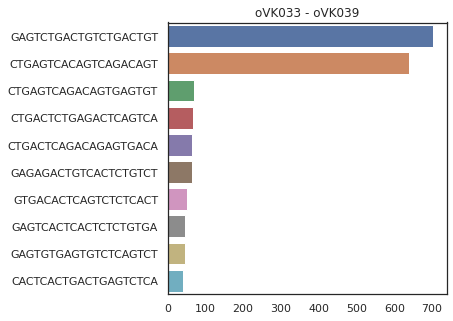

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(5,5))
fwd = 'oVK033'
rev = 'oVK039'
p=sns.barplot(x="count", y="barcode", 
            data=barcode_counts[
                (barcode_counts['forward_primer']==fwd) &
                (barcode_counts['reverse_primer']==rev)
            ].head(10),
            ci=None
           )
p.set(xlabel=None)
p.set(ylabel=None)
p.set(title=fwd + ' - ' + rev)

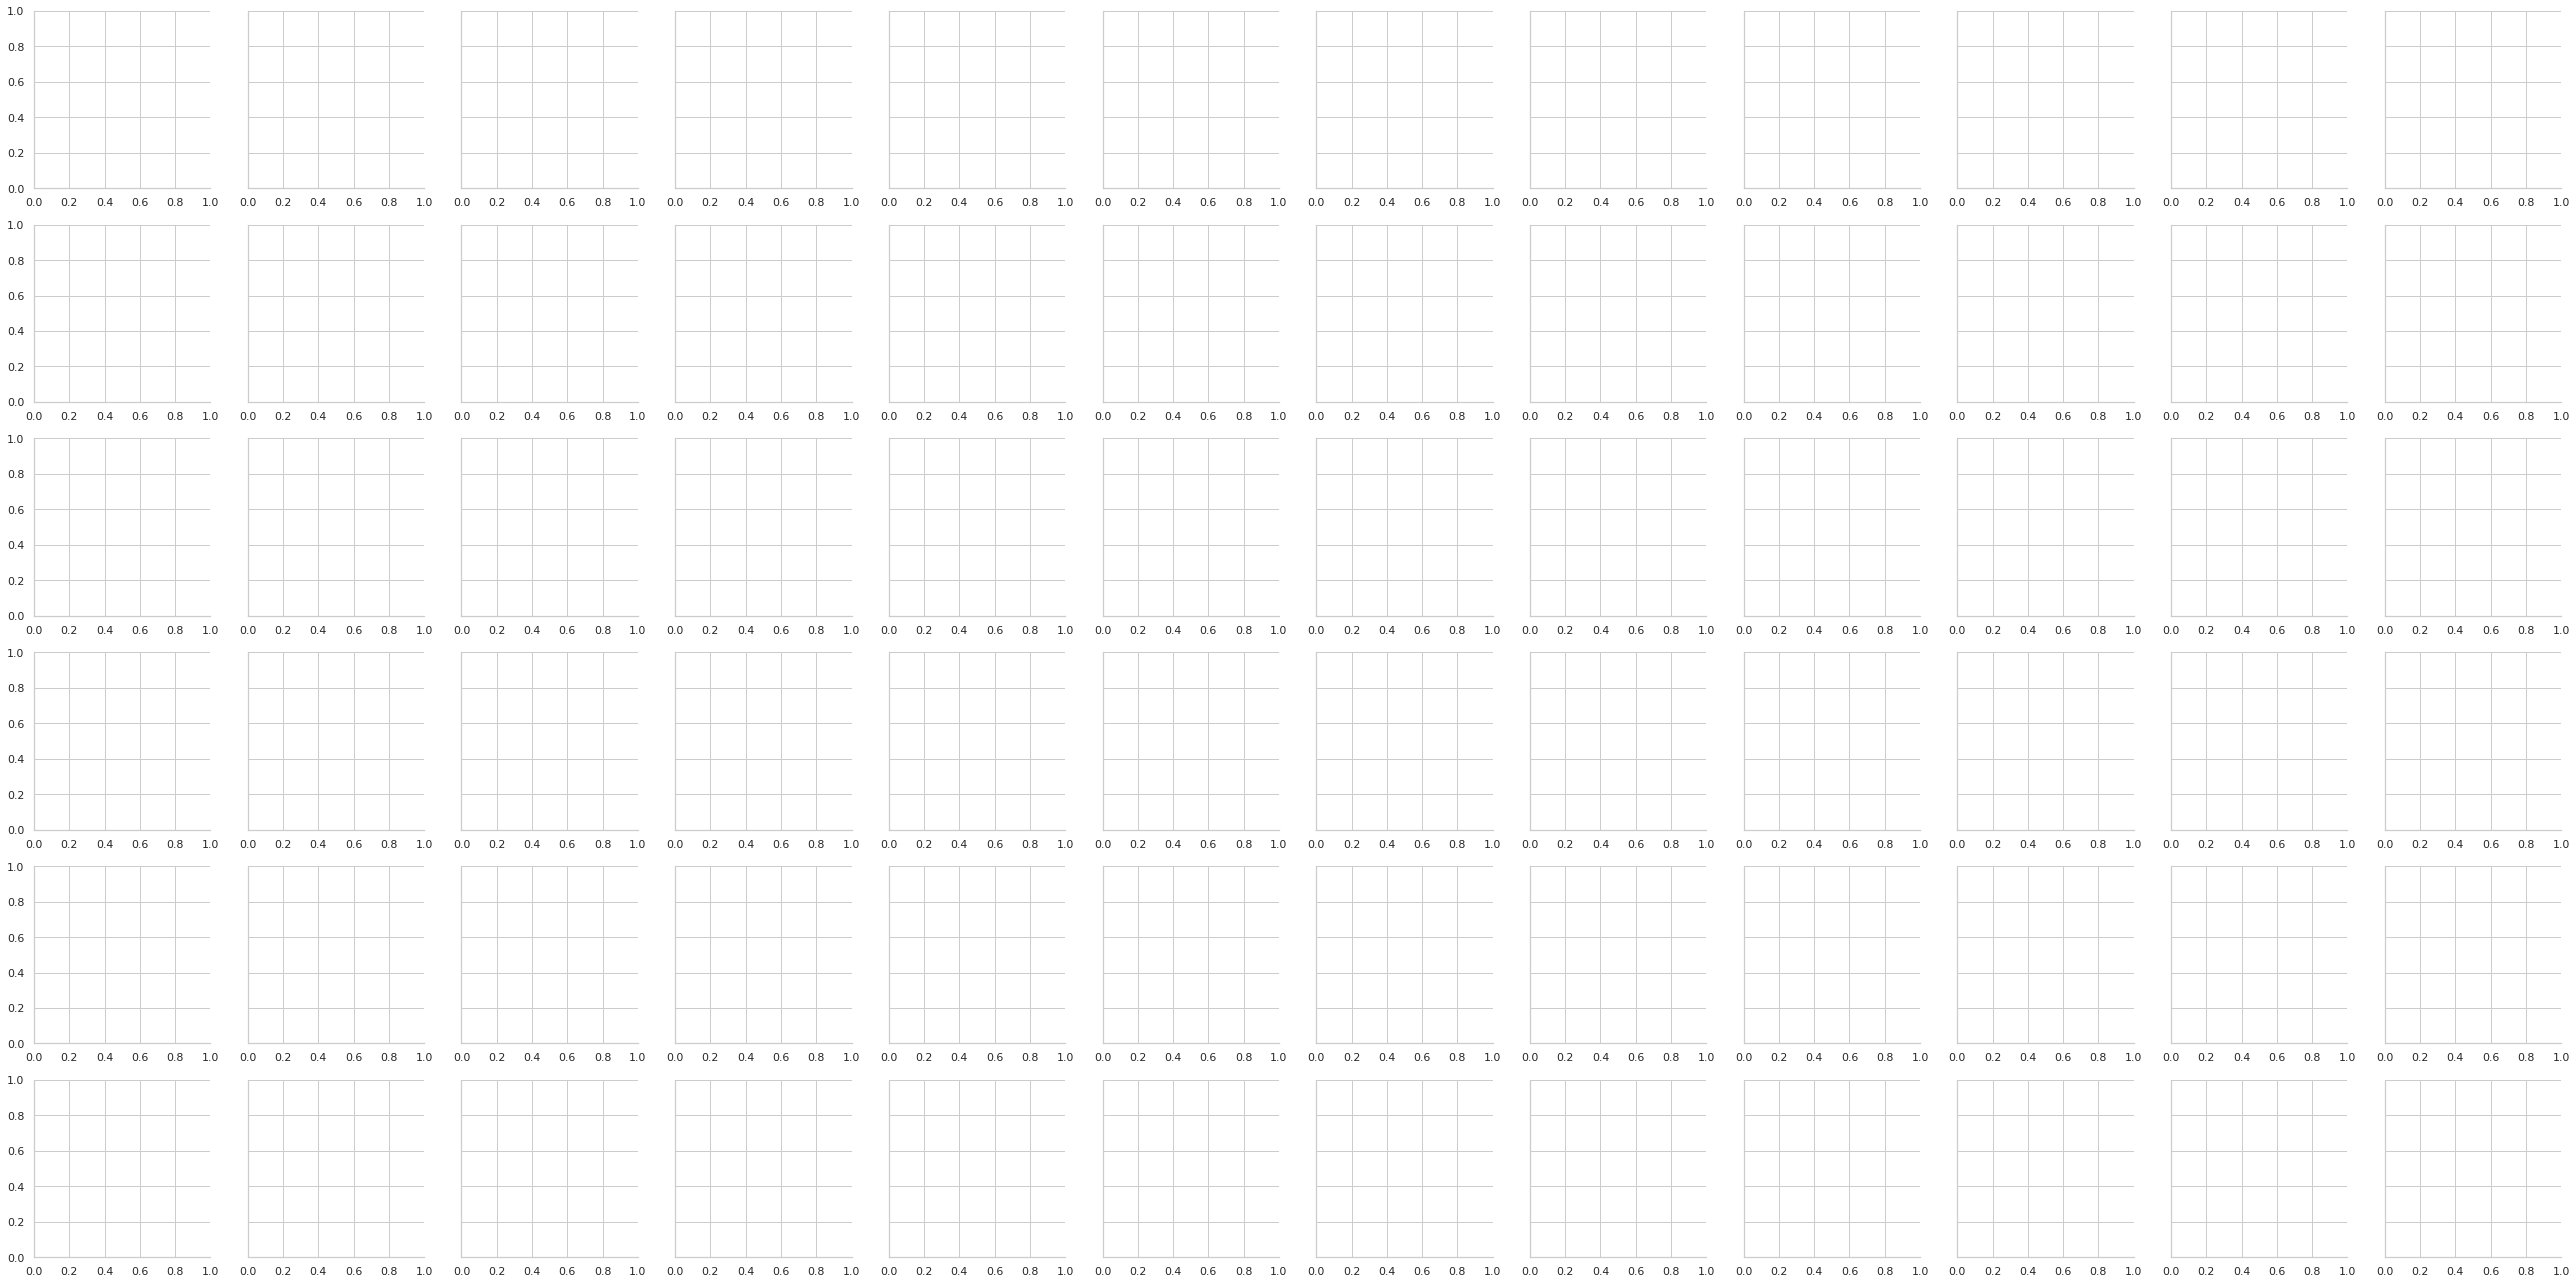

In [33]:
g=sns.FacetGrid(barcode_counts, col="reverse_primer", row="forward_primer", sharex=False)

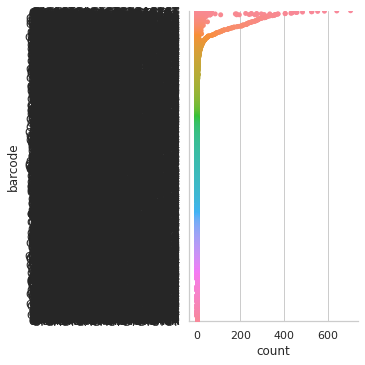

In [38]:
=sns.catplot(x="count",y="barcode",data=barcode_counts)

/opt/miniconda/envs/gatk/lib/python3.6/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


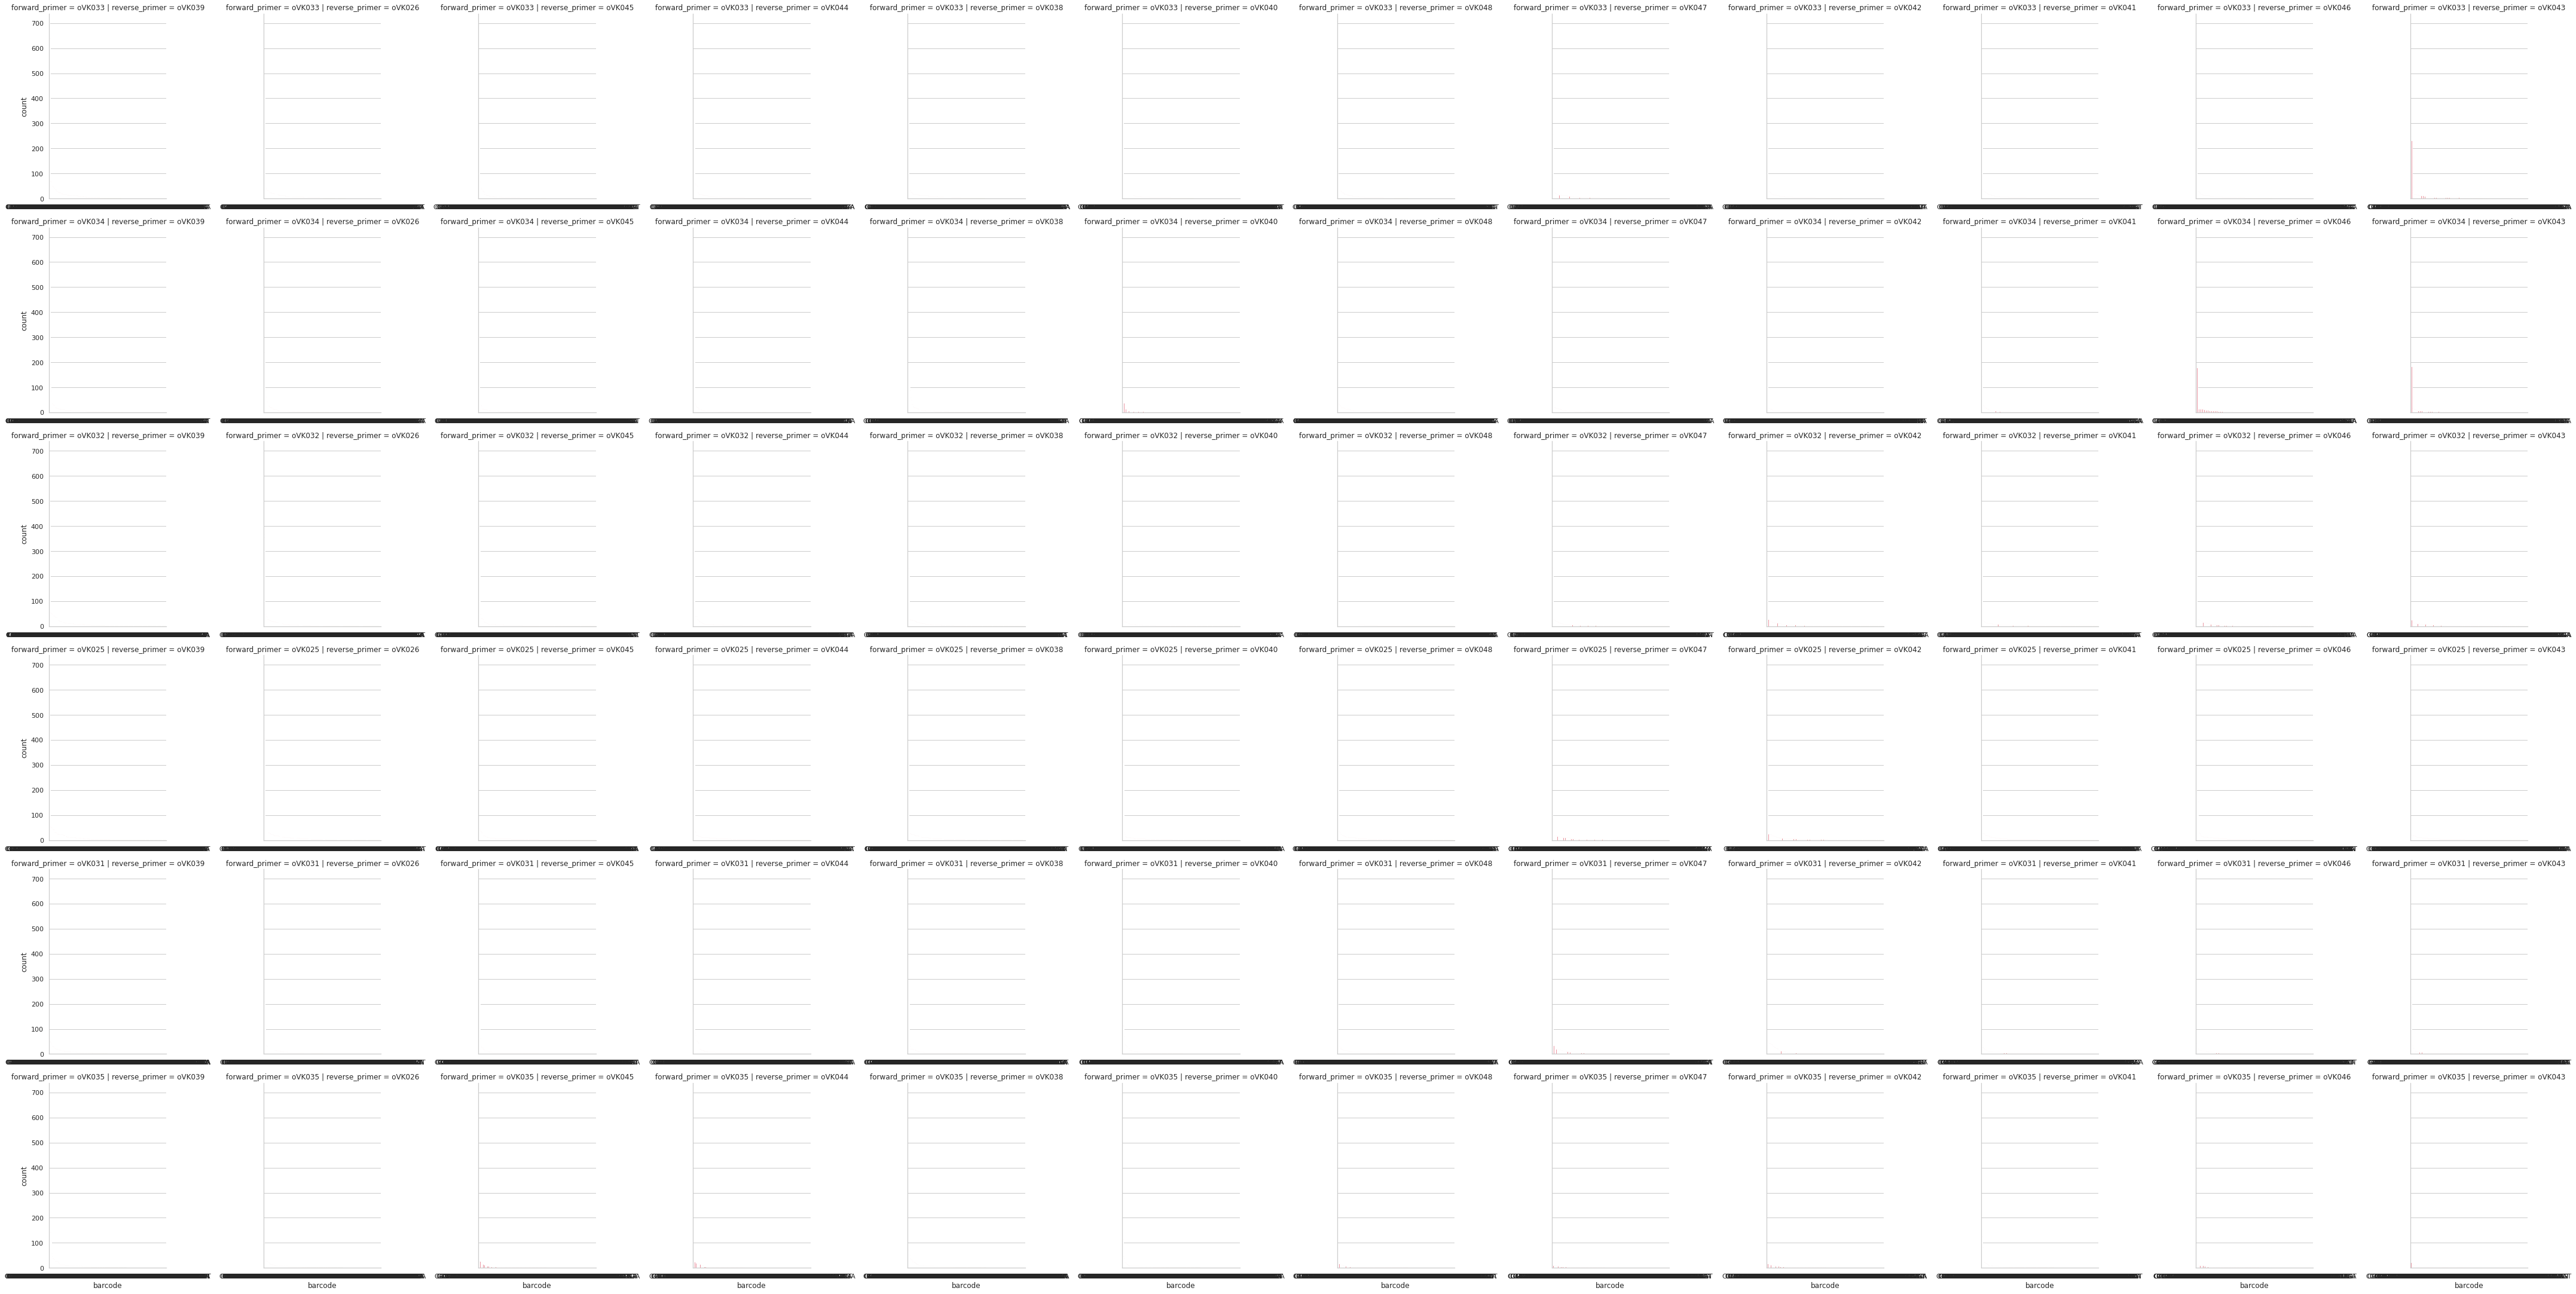

In [43]:
g2 = sns.catplot(y="count", x="barcode", row="forward_primer", col="reverse_primer",
                kind="bar", data=barcode_counts, ci=None, sharex=False)

In [56]:
barcode_table

{frozenset({'oVK025', 'oVK026'}): {'GTGTGTGTGTGAGACTGTGA': 437,
  'CTCACAGTCTCACACACACA': 405,
  'GTGTCACTGTCTCACTCTCA': 3,
  'CTGAGTCAGAGAGTGTGAGA': 9,
  'CTGAGAGTGTCTGACTCTGA': 5,
  'GTGAGTGTCTGTCAGTCTCA': 23,
  'CTCTCACTGACTCACACTCA': 3,
  'CTGAGTCACAGTCAGACAGT': 15,
  'CAGTCACAGTGTGTGTCAGT': 9,
  'CTCTCACAGTCTGACAGACA': 9,
  'CTGAGAGAGAGAGTGACAGT': 8,
  'CACACAGACTCAGACACACA': 17,
  'GAGTGTGAGTGTCTCAGTCT': 39,
  'CTGAGTGTGACAGAGTCAGT': 12,
  'GTCTGTGTGTCACTCTGTGA': 1,
  'GACTGTCACTCTCACAGACT': 7,
  'CTGACTCAGACTGAGACACT': 32,
  'CTGAGTGTCTGAGTGACTGA': 8,
  'GTCAGTGTCACTCTGACACA': 4,
  'CTGACTCTCTGAGTGTGTGA': 19,
  'CTGAGAGAGTGTGAGAGTGA': 20,
  'CTGAGTGTGACTGTGTCTGA': 9,
  'CTGACTCAGACAGAGTGACA': 39,
  'GTGTCACTCTCACACTCTCT': 8,
  'CTGAGTGTGAGTGAGAGTGA': 1,
  'CACTCACTGACTGAGTCTCA': 17,
  'GTCTCTCTCACTGACACAGT': 11,
  'GTGACACTCAGTCTCTCACT': 11,
  'CTGAGTGTGTGACTCTGTGA': 2,
  'GACTCTCTCTCTCACACTCA': 1,
  'CTGAGTGTGTGAGAGTCTGA': 1,
  'CAGTCACAGTCACTGTCAGA': 2,
  'CTGACTGACTCTGAGTGAGT

In [66]:
# Writing to an excel  
# sheet using Python 
import xlwt 
from xlwt import Workbook 
  
# Workbook is created 
wb = Workbook() 
  
for primer_pair in barcode_table:
    sheetname = ''
    print(primer_pair, sheetname)
    for p in primer_pair:
        sheetname += ' ' + p
    sheetname.strip(' ')
    sheet = wb.add_sheet(sheetname)
    row = 0
    bc_dict = barcode_table[primer_pair]
    for barcode in sorted(bc_dict.items(), key=lambda x: x[1], reverse=True):
        sheet.write(row, 0, barcode[0])
        sheet.write(row, 1, barcode[1])
        row += 1

wb.save('barcodes.xls') 


frozenset({'oVK025', 'oVK026'}) 
frozenset({'oVK025', 'oVK038'}) 
frozenset({'oVK025', 'oVK039'}) 
frozenset({'oVK025', 'oVK040'}) 
frozenset({'oVK041', 'oVK025'}) 
frozenset({'oVK042', 'oVK025'}) 
frozenset({'oVK043', 'oVK025'}) 
frozenset({'oVK044', 'oVK025'}) 
frozenset({'oVK045', 'oVK025'}) 
frozenset({'oVK025', 'oVK046'}) 
frozenset({'oVK025', 'oVK047'}) 
frozenset({'oVK048', 'oVK025'}) 
frozenset({'oVK031', 'oVK026'}) 
frozenset({'oVK031', 'oVK038'}) 
frozenset({'oVK031', 'oVK039'}) 
frozenset({'oVK031', 'oVK040'}) 
frozenset({'oVK041', 'oVK031'}) 
frozenset({'oVK042', 'oVK031'}) 
frozenset({'oVK043', 'oVK031'}) 
frozenset({'oVK044', 'oVK031'}) 
frozenset({'oVK045', 'oVK031'}) 
frozenset({'oVK031', 'oVK046'}) 
frozenset({'oVK031', 'oVK047'}) 
frozenset({'oVK031', 'oVK048'}) 
frozenset({'oVK032', 'oVK026'}) 
frozenset({'oVK032', 'oVK038'}) 
frozenset({'oVK032', 'oVK039'}) 
frozenset({'oVK032', 'oVK040'}) 
frozenset({'oVK032', 'oVK041'}) 
frozenset({'oVK032', 'oVK042'}) 
frozenset(

In [58]:
pip install xlwt

     |################################| 99 kB 5.3 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [73]:
for p in primer_table:
    p['Seq'] = Bio.Seq.Seq(p['sequence'])
primer_table

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F',
  'regex': re.compile(r'GCTACCTTGGATATTGCTGAAGAGCTTG', re.UNICODE),
  'Seq': Seq('GCTACCTTGGATATTGCTGAAGAGCTTG')},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F',
  'regex': re.compile(r'GCTGCCGAAGATATTGCTGAAGAGCTTG', re.UNICODE),
  'Seq': Seq('GCTGCCGAAGATATTGCTGAAGAGCTTG')},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F',
  'regex': re.compile(r'GCTACTGCTGATATTGCTGAAGAGCTTG', re.UNICODE),
  'Seq': Seq('GCTACTGCTGATATTGCTGAAGAGCTTG')},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F',
  'regex': re.compile(r'GCTGAACGTGATATTGCTGAAGAGCTTG', re.UNICODE),
  'Seq': Seq('GCTGAACGTGATATTGCTGAAGAGCTTG')},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  

In [75]:
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA'
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC'
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'
reference_barcode_regex = '([GC][AT]){9,10}'
reference_sequence_regex = reference_sequence_pre + '('+ reference_barcode_regex + ')' + reference_sequence_post

In [80]:
fl = 5
reference_sequence_pre[-fl:]

'TCTGA'

In [228]:
flanking_length = 1

barcode_regex = re.compile(
    reference_sequence_pre[-flanking_length:] + 
    '([GC][AT]){9,10}' +
    reference_sequence_post[:flanking_length]
)

barcode_regex_rc = re.compile(
    rcDNA( reference_sequence_post[:flanking_length] )+ 
    '([AT][GC]){9,10}' +
    rcDNA( reference_sequence_pre[-flanking_length:] )
)

def matchSequence(seq):
    primers = {'forward':[], 'forward_rc':[], 'reverse':[], 'reverse_rc':[]}
    barcode = ''
    for p in primer_table:
        if seq.find(p['sequence']) != -1:
            if p['direction'] == 'F':
                primers['forward'].append(p['OriginalSeq'])
            else:
                primers['reverse'].append(p['OriginalSeq'])
        if seq.find( rcDNA( p['sequence'] ) ) != -1:
            if p['direction'] == 'F':
                primers['forward_rc'].append(p['OriginalSeq'])
            else:
                primers['reverse_rc'].append(p['OriginalSeq'])
    m = barcode_regex.search(str(seq))
    if m != None:
        barcode = m.group(0)
    else:
        m = barcode_regex_rc.search(str(seq))
        if m != None:
            barcode = m.group(0)
    return {'primers': primers, 'barcode': barcode}

def matchPrimers(seq):
    primers = {'forward':[], 'reverse':[], 
               'direction':{'forward':True, 'reverse':False}}
    for p in primer_table:
        if seq.find(p['sequence']) != -1:
            if p['direction'] == 'F':
                primers['forward'].append(p['OriginalSeq'])
                primers['direction']['forward'] = True
            else:
                primers['reverse'].append(p['OriginalSeq'])
                primers['direction']['reverse'] = True
        if seq.find( rcDNA( p['sequence'] ) ) != -1:
            if p['direction'] == 'F':
                primers['forward'].append(p['OriginalSeq'])
                primers['direction']['forward'] = False
            else:
                primers['reverse'].append(p['OriginalSeq'])
                primers['direction']['reverse'] = False
    return primers

In [99]:
barcode_regex

re.compile(r'A([GC][AT]){9,10}A', re.UNICODE)

In [126]:
def addCountToDict(d, k):
    if k in d:
        d[k] += 1
    else:
        d[k] = 1    

In [145]:
read_table = pd.DataFrame(
    columns = ['R1_pre', 'R1_post', 'R1_barcode', 'R2_pre', 'R2_post', 'R2_barcode']
                         )

In [254]:
top_5prime = 'TTCTTGACGAGTTCTTCTGA'
top_3prime = 'ACGCGTCTGGAACAATCAAC'
bottom_3prime = 'TCAGAAGAACTCGTCAAGAA'
bottom_5prime = 'GTTGATTGTTCCAGACGCGT'
topstrand_re = re.compile('(?P<pre>' + top_5prime + ')(?P<barcode>[ATGC]+)(?P<post>' + top_3prime + ')')
botstrand_re = re.compile('(?P<pre>' + bottom_5prime + ')(?P<barcode>[ATGC]+)(?P<post>' + bottom_3prime + ')')

R1 = gzip.open("VK001_R1_001.fastq.gz", "rt")
R2 = gzip.open("VK001_R2_001.fastq.gz", "rt")
reads1 = SeqIO.parse(R1, "fastq")
reads2 = SeqIO.parse(R2, "fastq")
counts_table = pd.DataFrame(data=0,index=forward_primers, columns=reverse_primers,dtype=int)
maxReads = 150000
readNumber = 0
unassigned_reads = []
all_reads = []
flanking_pre = {}
flanking_post = {}
bc_re = re.compile(reference_sequence_regex)
for (read1, read2) in zip(reads1, reads2):
    match1 = matchSequence(read1.seq)
    match2 = matchSequence(read2.seq)
    new_row = {'R1_pre':'', 'R1_post':'', 'R1_barcode':'', 'R2_pre':'', 'R2_post':'', 'R2_barcode':''}
    #print(match1, match2)
    # barcode_re = re.compile('(.....)(([AT][GC]){10})(.....)') 
    # barcode_re = re.compile('(GTTCTTCTGA)' + '([ATGC]+)' + '(ACGCGTCTGG)')
    m = topstrand_re.search(str( read1.seq ))
    if m != None:
        #print(m.group('pre') + ' ' + m.group('barcode') + ' ' + m.group('post'))
        new_row['R1_pre'] = m.group('pre')
        new_row['R1_post'] = m.group('post')
        new_row['R1_barcode'] = m.group('barcode')
        addCountToDict(flanking_pre, m.group('pre'))
        addCountToDict(flanking_post,m.group('post'))
    else:
        m = botstrand_re.search(str( read1.seq ))
        if m != None:
            #print(m.group('pre') + ' ' + m.group('barcode') + ' ' + m.group('post'))
            new_row['R1_pre'] = m.group('pre')
            new_row['R1_post'] = m.group('post')
            new_row['R1_barcode'] = m.group('barcode')
            addCountToDict(flanking_pre, m.group('pre'))
            addCountToDict(flanking_post,m.group('post'))
    m = topstrand_re.search(str( read2.seq ))
    if m != None:
        #print(m.group('pre') + ' ' + m.group('barcode') + ' ' + m.group('post'))
        new_row['R2_pre'] = m.group('pre')
        new_row['R2_post'] = m.group('post')
        new_row['R2_barcode'] = m.group('barcode')
        addCountToDict(flanking_pre, m.group('pre'))
        addCountToDict(flanking_post,m.group('post'))
    else:
        m = botstrand_re.search(str( read2.seq ))
        if m != None:
            #print(m.group('pre') + ' ' + m.group('barcode') + ' ' + m.group('post'))
            new_row['R2_pre'] = m.group('pre')
            new_row['R2_post'] = m.group('post')
            new_row['R2_barcode'] = m.group('barcode')
            addCountToDict(flanking_pre, m.group('pre'))
            addCountToDict(flanking_post,m.group('post'))
    
    primers = matchPrimers(read1.seq)
    if len(primers['forward']) == 1:
        new_row['R1_primer_fwd'] = primers['forward'][0]
    if len(primers['reverse']) == 1:
        new_row['R1_primer_rev'] = primers['reverse'][0]
    primers = matchPrimers(read2.seq)
    if len(primers['forward']) == 1:
        new_row['R2_primer_fwd'] = primers['forward'][0]
    if len(primers['reverse']) == 1:
        new_row['R2_primer_rev'] = primers['reverse'][0]
    try:
        new_row['primer_direction'] = primers['direction']['forward']
    except:
        new_row['primer_direction'] = np.nan
        
    # print(new_row)
    all_reads.append(new_row)
    read_table.append(new_row, ignore_index=True)
    readNumber += 1
    if readNumber > maxReads:
        break
R1.close()
R2.close()

#print(flanking_pre)
#print(flanking_post)

In [255]:
read_table = pd.DataFrame(all_reads)

In [256]:
read_table

,R1_pre,R1_post,R1_barcode,R2_pre,R2_post,R2_barcode,R2_primer_rev,primer_direction,R1_primer_fwd,R1_primer_rev,R2_primer_fwd
0,,,,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CAGACTCACAGACTCTGAGTCTCACTCAGT,oVK026,True,NaN,NaN,NaN
1,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,oVK044,False,oVK033,oVK044,oVK033
2,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TGAGTGTGAGTGTCTCAGTCTGAG,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACTGAGACACTCACACTCA,NaN,True,NaN,NaN,NaN
3,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGAGAGTGACAGTGACTCAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGAGTCACTGTCACTCTCTCTC,oVK047,False,oVK032,oVK047,oVK032
4,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,oVK040,True,oVK033,oVK040,oVK033
...,...,...,...,...,...,...,...,...,...,...,...
149751,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGTCACTCACTCTCACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTGAGAGTGAGTGACTCT,oVK048,True,NaN,oVK048,NaN
149752,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,oVK047,True,oVK025,oVK047,oVK025
149753,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACAGAGTGACAGTCTCTCT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGAGACTGTCACTCTGTCTGAG,oVK040,False,oVK033,oVK040,oVK033
149754,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTCAGTGTCAGAGTCAGAGTGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCACTCTGACTCTGACACTGAGTC,oVK039,False,oVK033,oVK039,oVK033


In [257]:
read_table = read_table[
    (read_table['R1_primer_fwd'] == read_table['R2_primer_fwd']) &
    (read_table['R1_primer_rev'] == read_table['R2_primer_rev'])
]

In [258]:
read_table

,R1_pre,R1_post,R1_barcode,R2_pre,R2_post,R2_barcode,R2_primer_rev,primer_direction,R1_primer_fwd,R1_primer_rev,R2_primer_fwd
1,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,oVK044,False,oVK033,oVK044,oVK033
3,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGAGAGTGACAGTGACTCAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGAGTCACTGTCACTCTCTCTC,oVK047,False,oVK032,oVK047,oVK032
4,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,oVK040,True,oVK033,oVK040,oVK033
5,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CACTGTCTGTCAGACTGTGAGAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTCTCACAGTCTGACAGACAGTG,oVK038,False,oVK033,oVK038,oVK033
7,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,oVK045,False,oVK031,oVK045,oVK031
...,...,...,...,...,...,...,...,...,...,...,...
149743,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTGAGTGTGACAGTGACACAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGTGTCACTGTCACACTCAGTC,oVK026,False,oVK031,oVK026,oVK031
149752,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,oVK047,True,oVK025,oVK047,oVK025
149753,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACAGAGTGACAGTCTCTCT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGAGACTGTCACTCTGTCTGAG,oVK040,False,oVK033,oVK040,oVK033
149754,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTCAGTGTCAGAGTCAGAGTGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCACTCTGACTCTGACACTGAGTC,oVK039,False,oVK033,oVK039,oVK033


In [259]:
read_table['primer_fwd'] = read_table['R1_primer_fwd']
read_table['primer_rev'] = read_table['R1_primer_rev']
read_table = read_table.drop(columns=['R1_primer_fwd','R1_primer_rev','R2_primer_fwd','R2_primer_rev'])
read_table

/opt/miniconda/envs/gatk/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda/envs/gatk/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,R1_pre,R1_post,R1_barcode,R2_pre,R2_post,R2_barcode,primer_direction,primer_fwd,primer_rev
1,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,False,oVK033,oVK044
3,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGAGAGTGACAGTGACTCAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGAGTCACTGTCACTCTCTCTC,False,oVK032,oVK047
4,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,oVK033,oVK040
5,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CACTGTCTGTCAGACTGTGAGAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTCTCACAGTCTGACAGACAGTG,False,oVK033,oVK038
7,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,False,oVK031,oVK045
...,...,...,...,...,...,...,...,...,...
149743,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTGAGTGTGACAGTGACACAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGTGTCACTGTCACACTCAGTC,False,oVK031,oVK026
149752,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,True,oVK025,oVK047
149753,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACAGAGTGACAGTCTCTCT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGAGACTGTCACTCTGTCTGAG,False,oVK033,oVK040
149754,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTCAGTGTCAGAGTCAGAGTGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCACTCTGACTCTGACACTGAGTC,False,oVK033,oVK039


In [260]:
read_table['R1_pre'].map(rcDNA)

1         TCAGAAGAACTCGTCAAGAA
3         TCAGAAGAACTCGTCAAGAA
4         ACGCGTCTGGAACAATCAAC
5         TCAGAAGAACTCGTCAAGAA
7         TCAGAAGAACTCGTCAAGAA
                  ...         
149743    TCAGAAGAACTCGTCAAGAA
149752    ACGCGTCTGGAACAATCAAC
149753    TCAGAAGAACTCGTCAAGAA
149754    TCAGAAGAACTCGTCAAGAA
149755    ACGCGTCTGGAACAATCAAC
Name: R1_pre, Length: 95438, dtype: object

In [261]:
read_table['rc_R2_post'] = read_table['R2_post'].map(rcDNA)
read_table['rc_R2_pre'] = read_table['R2_pre'].map(rcDNA)
read_table['primers_match'] = (read_table['R1_pre'] == read_table['rc_R2_post']) & (read_table['R1_post'] == read_table['rc_R2_pre'])
read_table[read_table['primers_match'] == True]

,R1_pre,R1_post,R1_barcode,R2_pre,R2_post,R2_barcode,primer_direction,primer_fwd,primer_rev,rc_R2_post,rc_R2_pre,primers_match
1,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,False,oVK033,oVK044,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True
3,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGAGAGTGACAGTGACTCAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGAGTCACTGTCACTCTCTCTC,False,oVK032,oVK047,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True
4,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,oVK033,oVK040,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True
5,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CACTGTCTGTCAGACTGTGAGAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTCTCACAGTCTGACAGACAGTG,False,oVK033,oVK038,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True
7,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,False,oVK031,oVK045,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True
...,...,...,...,...,...,...,...,...,...,...,...,...
149743,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTGAGTGTGACAGTGACACAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGTGTCACTGTCACACTCAGTC,False,oVK031,oVK026,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True
149752,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,True,oVK025,oVK047,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True
149753,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACAGAGTGACAGTCTCTCT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGAGACTGTCACTCTGTCTGAG,False,oVK033,oVK040,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True
149754,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTCAGTGTCAGAGTCAGAGTGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCACTCTGACTCTGACACTGAGTC,False,oVK033,oVK039,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True


In [262]:
read_table['rc_R2_barcode'] = read_table['R2_barcode'].map(rcDNA)
read_table['barcodes_match'] = read_table['rc_R2_barcode'] == read_table['R1_barcode']
read_table[read_table['barcodes_match'] == True]

,R1_pre,R1_post,R1_barcode,R2_pre,R2_post,R2_barcode,primer_direction,primer_fwd,primer_rev,rc_R2_post,rc_R2_pre,primers_match,rc_R2_barcode,barcodes_match
1,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,False,oVK033,oVK044,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GTGTGACTGTGTCTGAGTGACAGTCAGT,True
3,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGAGAGTGACAGTGACTCAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGAGTCACTGTCACTCTCTCTC,False,oVK032,oVK047,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GAGAGAGAGTGACAGTGACTCAGA,True
4,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,oVK033,oVK040,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True,ACTGACTGTCACTCAGACACAGTCACAC,True
5,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CACTGTCTGTCAGACTGTGAGAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTCTCACAGTCTGACAGACAGTG,False,oVK033,oVK038,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,CACTGTCTGTCAGACTGTGAGAGA,True
7,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,False,oVK031,oVK045,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GAGAGTGTAGTGTGTGAGAGTGT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149743,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTGAGTGTGACAGTGACACAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGTGTCACTGTCACACTCAGTC,False,oVK031,oVK026,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GACTGAGTGTGACAGTGACACAGA,True
149752,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,True,oVK025,oVK047,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True,ACACTCTCACACACTACACTCTC,True
149753,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACAGAGTGACAGTCTCTCT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGAGACTGTCACTCTGTCTGAG,False,oVK033,oVK040,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,CTCAGACAGAGTGACAGTCTCTCT,True
149754,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTCAGTGTCAGAGTCAGAGTGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCACTCTGACTCTGACACTGAGTC,False,oVK033,oVK039,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GACTCAGTGTCAGAGTCAGAGTGA,True


In [263]:
read_table['barcode'] = read_table['R1_barcode']
read_table['barcode'] = read_table['barcode'].where( read_table['primer_direction'] == True, read_table['R2_barcode'])

In [264]:
read_table

,R1_pre,R1_post,R1_barcode,R2_pre,R2_post,R2_barcode,primer_direction,primer_fwd,primer_rev,rc_R2_post,rc_R2_pre,primers_match,rc_R2_barcode,barcodes_match,barcode
1,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,False,oVK033,oVK044,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,ACTGACTGTCACTCAGACACAGTCACAC
3,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGAGAGTGACAGTGACTCAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGAGTCACTGTCACTCTCTCTC,False,oVK032,oVK047,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GAGAGAGAGTGACAGTGACTCAGA,True,TCTGAGTCACTGTCACTCTCTCTC
4,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,oVK033,oVK040,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True,ACTGACTGTCACTCAGACACAGTCACAC,True,ACTGACTGTCACTCAGACACAGTCACAC
5,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CACTGTCTGTCAGACTGTGAGAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTCTCACAGTCTGACAGACAGTG,False,oVK033,oVK038,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,CACTGTCTGTCAGACTGTGAGAGA,True,TCTCTCACAGTCTGACAGACAGTG
7,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,False,oVK031,oVK045,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GAGAGTGTAGTGTGTGAGAGTGT,True,ACACTCTCACACACTACACTCTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149743,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTGAGTGTGACAGTGACACAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGTGTCACTGTCACACTCAGTC,False,oVK031,oVK026,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GACTGAGTGTGACAGTGACACAGA,True,TCTGTGTCACTGTCACACTCAGTC
149752,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,True,oVK025,oVK047,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True,ACACTCTCACACACTACACTCTC,True,ACACTCTCACACACTACACTCTC
149753,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACAGAGTGACAGTCTCTCT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGAGACTGTCACTCTGTCTGAG,False,oVK033,oVK040,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,CTCAGACAGAGTGACAGTCTCTCT,True,AGAGAGACTGTCACTCTGTCTGAG
149754,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTCAGTGTCAGAGTCAGAGTGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCACTCTGACTCTGACACTGAGTC,False,oVK033,oVK039,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GACTCAGTGTCAGAGTCAGAGTGA,True,TCACTCTGACTCTGACACTGAGTC


In [265]:
good_reads = read_table[
    (read_table['primers_match'] == True) &
    (read_table['barcodes_match'] == True)
    ]

In [266]:
good_reads

,R1_pre,R1_post,R1_barcode,R2_pre,R2_post,R2_barcode,primer_direction,primer_fwd,primer_rev,rc_R2_post,rc_R2_pre,primers_match,rc_R2_barcode,barcodes_match,barcode
1,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,False,oVK033,oVK044,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,ACTGACTGTCACTCAGACACAGTCACAC
3,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGAGAGTGACAGTGACTCAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGAGTCACTGTCACTCTCTCTC,False,oVK032,oVK047,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GAGAGAGAGTGACAGTGACTCAGA,True,TCTGAGTCACTGTCACTCTCTCTC
4,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACTGACTGTCACTCAGACACAGTCACAC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,oVK033,oVK040,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True,ACTGACTGTCACTCAGACACAGTCACAC,True,ACTGACTGTCACTCAGACACAGTCACAC
5,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CACTGTCTGTCAGACTGTGAGAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTCTCACAGTCTGACAGACAGTG,False,oVK033,oVK038,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,CACTGTCTGTCAGACTGTGAGAGA,True,TCTCTCACAGTCTGACAGACAGTG
7,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,False,oVK031,oVK045,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GAGAGTGTAGTGTGTGAGAGTGT,True,ACACTCTCACACACTACACTCTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149743,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTGAGTGTGACAGTGACACAGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCTGTGTCACTGTCACACTCAGTC,False,oVK031,oVK026,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GACTGAGTGTGACAGTGACACAGA,True,TCTGTGTCACTGTCACACTCAGTC
149752,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,ACACTCTCACACACTACACTCTC,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GAGAGTGTAGTGTGTGAGAGTGT,True,oVK025,oVK047,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,True,ACACTCTCACACACTACACTCTC,True,ACACTCTCACACACTACACTCTC
149753,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,CTCAGACAGAGTGACAGTCTCTCT,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,AGAGAGACTGTCACTCTGTCTGAG,False,oVK033,oVK040,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,CTCAGACAGAGTGACAGTCTCTCT,True,AGAGAGACTGTCACTCTGTCTGAG
149754,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,GACTCAGTGTCAGAGTCAGAGTGA,GTTGATTGTTCCAGACGCGT,TCAGAAGAACTCGTCAAGAA,TCACTCTGACTCTGACACTGAGTC,False,oVK033,oVK039,TTCTTGACGAGTTCTTCTGA,ACGCGTCTGGAACAATCAAC,True,GACTCAGTGTCAGAGTCAGAGTGA,True,TCACTCTGACTCTGACACTGAGTC


In [267]:
good_reads[['primer_fwd','primer_rev','barcode','barcodes_match']].groupby(['primer_fwd','primer_rev','barcode']).agg(['count'])

barcodes_match
                                                        count
primer_fwd primer_rev barcode                                
oVK025     oVK026                                          21
                      ACACACAGACACTCTGACAGTGTC              1
                      ACACAGTGTGTGTGACAGAGAGTG              1
                      ACACTCAGACTGTCTCTGACACAG             19
                      ACACTCTCACACACTACACTCTC             108
...                                                       ...
oVK035     oVK048     TGTGTCACTCTCACACTCTCTGAC             43
                      TGTGTCACTGTCTCACTCTCAGAG              3
                      TGTGTCTCACTCTCAGACTGACAG              1
                      TGTGTCTGTCTCACACAGTGAGTC              1
                      TGTGTGACTGACACTCTCACTCTG              5

[6309 rows x 1 columns]

In [269]:
counts_table = good_reads.groupby(['primer_fwd','primer_rev','barcode']).size().reset_index(name='count').sort_values(
    by=['primer_fwd','primer_rev','count'], ascending=[True,True,False]
)
counts_table

,primer_fwd,primer_rev,barcode,count
15,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166
4,oVK025,oVK026,ACACTCTCACACACTACACTCTC,108
41,oVK025,oVK026,AGAGTCACTCACTCTCTGTGAGAC,52
78,oVK025,oVK026,TCTGTGTCACTGTCACACTCAGTC,50
45,oVK025,oVK026,AGTGAGTGTCTGTCAGTCTCAGTG,46
...,...,...,...,...
6298,oVK035,oVK048,TGTCTCACTCTGTCAGTGTGAGTG,1
6302,oVK035,oVK048,TGTGTCACACACTCTCTCACTCTC,1
6303,oVK035,oVK048,TGTGTCACACTGTGTGTCTCAGAC,1
6306,oVK035,oVK048,TGTGTCTCACTCTCAGACTGACAG,1


In [272]:
pip install openpyxl

     |################################| 242 kB 8.2 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8915 sha256=e5028d2c7f1cfe5214554e07671ae596df434178f35102feb5ee88217cacb450
  Stored in directory: /root/.cache/pip/wheels/ef/92/e0/956c00decf3091294b8800d9104f6169a1adacfaafd122ed42
Successfully built et-xmlfile
Note: you may need to restart the kernel to use updated packages.


In [273]:
with pd.ExcelWriter('primer_barcode_counts.xlsx') as writer:
    counts_table.to_excel(writer)

In [275]:
counts_table[counts_table['count'] > 50]

,primer_fwd,primer_rev,barcode,count
15,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166
4,oVK025,oVK026,ACACTCTCACACACTACACTCTC,108
41,oVK025,oVK026,AGAGTCACTCACTCTCTGTGAGAC,52
130,oVK025,oVK038,AGTCAGACACTGACTCTGTCACAC,951
97,oVK025,oVK038,ACACTCTCACACACTACACTCTC,89
...,...,...,...,...
5694,oVK035,oVK041,TCTGACTCTCACACAGTCTCAAG,65
5799,oVK035,oVK043,ACACTCTCACACACTACACTCTC,57
5948,oVK035,oVK044,TGAGTGTGAGTGTCTCAGTCTGAG,73
5954,oVK035,oVK045,,66


In [386]:
jw_counts = pd.read_table(
    'jiwoong/VK001.barcode_pair_sequence.count.txt',
    names=['primer1','primer2','sequence','count']
)

In [387]:
jw_counts[['primer1','primer2','sequence']].groupby(['primer1','primer2','sequence']).size().reset_index(name='count').sort_values(
    by=['count'], ascending=[False])

,primer1,primer2,sequence,count
0,F_oVK025,F_oVK031,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC,1
5450,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
5463,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
5462,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
5461,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
...,...,...,...,...
2722,F_oVK032,R_oVK038,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCACCGC...,1
2721,F_oVK032,R_oVK038,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATAGCCGC...,1
2720,F_oVK032,R_oVK038,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACAGTATCGCCGC...,1
2719,F_oVK032,R_oVK038,GCGGCGAATGGGCTGACCGCTTCCTCGTCCTTTACGGTATCGCCGC...,1


In [388]:
jw_counts

,primer1,primer2,sequence,count
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545
...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1


In [381]:
def StripBarcode(seq, lseq=reference_sequence_pre, rseq='ACGCG'):
    p = seq.find(lseq)
    return seq[p + len(lseq):].rstrip(rseq)

In [385]:
StripBarcode('AAAACTAAAAGGG','CTA','GGG')

'AAA'

In [330]:
jw_counts['sequence'][1]

'GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTCAGACAGTGAGTGTCACTCACAACGCG'

In [382]:
StripBarcode(jw_counts['sequence'][1])

'GTCAGACAGTGAGTGTCACT'

In [292]:
reference_sequence_pre

'TTCTTGACGAGTTCTTCTGA'

In [389]:
jw_counts['barcode'] = jw_counts['sequence'].map(StripBarcode)

In [390]:
jw_counts[['primer1','primer2','barcode']].groupby(['primer1','primer2','barcode']).size().reset_index(name='count').sort_values(
    by=['count'], ascending=[False])

,primer1,primer2,barcode,count
3586,F_oVK033,R_oVK039,GTCACAGTCAGACAGTCAGACT,19
285,F_oVK025,R_oVK039,GAGACACAGTGACTCACAGTGTCT,18
5118,F_oVK034,R_oVK044,CTCAGACAGAGTGACAGTCTCTCT,16
1368,F_oVK031,R_oVK039,GAGAGTGTAGTGTGTGAGAGTGT,16
4246,F_oVK033,R_oVK047,GTCAGTGAGAGACTGAGTGT,15
...,...,...,...,...
2516,F_oVK032,R_oVK039,GAGAGAGTGTCACTGTGTGTCTGTCT,1
2515,F_oVK032,R_oVK039,GAGAGAGTGACAGTGACT,1
2513,F_oVK032,R_oVK039,GAGACACTCTCTCAGACTCT,1
2512,F_oVK032,R_oVK039,GAGACACAGTGACTCACAGTGTCT,1


In [368]:
jw_counts[jw_counts['count'] > 50]

,primer1,primer2,sequence,count,barcode
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,GTCACAGTCAGACAGTCAGACT
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,GTCAGACAGTGAGTGTCACT
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,CTCTGAGACTCAGTCAGTGAGT
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,GAGACACAGTGACTCACAGTGTCT
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,GAGAGTGTAGTGTGTGAGAGTGT
...,...,...,...,...,...
275,F_oVK025,R_oVK042,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,51,GAGTGTCTGACTCTGAGTGAGT
276,F_oVK031,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,51,GTGTCTGAGTGACTGAGAGT
277,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,51,GTGTCTGAGACAGAGACTGTCAGT
278,F_oVK034,R_oVK042,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,51,GTGAGTCAGTCACACTGT


In [299]:
'F_oVK025'[-6:]

'oVK025'

In [304]:
def PrimerID(p1, p2):
    primers = {'forward':'', 'reverse':''}
    if p1[-6:] in forward_primers:
        primers['forward'] = p1[-6:]
    elif p1[-6:] in reverse_primers:
        primers['reverse'] = p1[-6:]
    if p2[-6:] in forward_primers:
        primers['forward'] = p2[-6:]
    elif p2[-6:] in reverse_primers:
        primers['reverse'] = p2[-6:]
    return primers

def FwdPrimer(p1, p2):
    return PrimerID(p1,p2)['forward']

def RevPrimer(p1, p2):
    return PrimerID(p1,p2)['reverse']

In [302]:
PrimerID(jw_counts['primer1'][1], jw_counts['primer2'][1])

{'forward': 'oVK034', 'reverse': 'oVK039'}

In [394]:
jw_counts['primer_fwd'] = jw_counts.apply(lambda x: FwdPrimer(x.primer1, x.primer2), axis=1)
jw_counts['primer_rev'] = jw_counts.apply(lambda x: RevPrimer(x.primer1, x.primer2), axis=1)

In [395]:
jw_counts

,primer1,primer2,sequence,count,barcode,primer_fwd,primer_rev
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,GTCACAGTCAGACAGTCAGACT,oVK033,oVK039
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,GTCAGACAGTGAGTGTCACT,oVK034,oVK039
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,CTCTGAGACTCAGTCAGTGAGT,oVK032,oVK039
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,GAGACACAGTGACTCACAGTGTCT,oVK025,oVK039
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,GAGAGTGTAGTGTGTGAGAGTGT,oVK031,oVK039
...,...,...,...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CTGTGTGTGTCTGAGTCTGTGT,oVK037,oVK045
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CTCTCTGTGTGTGTGT,oVK037,oVK046
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,GAGAGTGTGAGAGTGAGTGACTCT,oVK037,oVK047
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,GTGTGTGAGTGTGTCTGTCTGAGT,oVK037,oVK047


In [351]:
merged_counts = pd.merge(left=counts_table, right=jw_counts, on=['primer_fwd','primer_rev'])

In [352]:
merged_counts

,primer_fwd,primer_rev,barcode_x,count_x,barcode_length,primer1,primer2,sequence,count_y,barcode_y
0,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166,24,F_oVK025,R_oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1448,AAGTGTGTGTGTGAGACTGTGAGT
1,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166,24,F_oVK025,R_oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,160,GAGAGTGTAGTGTGTGAGAGTGT
2,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166,24,F_oVK025,R_oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,73,GTCTCACAGAGAGTGAGTGACTCT
3,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166,24,F_oVK025,R_oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,70,CACTGAGACTGACAGACACTCACT
4,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166,24,F_oVK025,R_oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,70,GACTGAGTGTGACAGT
...,...,...,...,...,...,...,...,...,...,...
794718,oVK035,oVK048,TGTGTCTGTCTCACACAGTGAGTC,1,24,F_oVK035,R_oVK048,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,GTGTGTCTGTGAGTGAGACTCTCT
794719,oVK035,oVK048,TGTGTCTGTCTCACACAGTGAGTC,1,24,F_oVK035,R_oVK048,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,GTGTGTGTGTCAGTCAGTGACTCT
794720,oVK035,oVK048,TGTGTCTGTCTCACACAGTGAGTC,1,24,F_oVK035,R_oVK048,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,GTGTGTGTGTGTCTCTCTGACTGT
794721,oVK035,oVK048,TGTGTCTGTCTCACACAGTGAGTC,1,24,F_oVK035,R_oVK048,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CTGTCAGTCTGAGAGT


In [396]:
jw_counts['c_barcode']=jw_counts['barcode']
jw_counts['barcode'] = jw_counts['barcode'].map(rcDNA)

In [335]:
jw_counts

,primer1,primer2,sequence,count,barcode,primer_fwd,primer_rev,c_barcode
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,CGCGTTGAGTCTGACTGTCTGACTGTGAC,oVK033,oVK039,GTCACAGTCAGACAGTCAGACTCAACGCG
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,CGCGTTGTGAGTGACACTCACTGTCTGAC,oVK034,oVK039,GTCAGACAGTGAGTGTCACTCACAACGCG
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,CGCGTTCACTCACTGACTGAGTCTCAGAG,oVK032,oVK039,CTCTGAGACTCAGTCAGTGAGTGAACGCG
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,CGCGTAGACACTGTGAGTCACTGTGTCTC,oVK025,oVK039,GAGACACAGTGACTCACAGTGTCTACGCG
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,CGCGTACACTCTCACACACTACACTCTC,oVK031,oVK039,GAGAGTGTAGTGTGTGAGAGTGTACGCG
...,...,...,...,...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CGCGTTCACACAGACTCAGACACACACAG,oVK037,oVK045,CTGTGTGTGTCTGAGTCTGTGTGAACGCG
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CGCGTTCTCTCTGACACACACACAGAGAG,oVK037,oVK046,CTCTCTGTGTGTGTGTCAGAGAGAACGCG
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CGCGTAGAGTCACTCACTCTCACACTCTC,oVK037,oVK047,GAGAGTGTGAGAGTGAGTGACTCTACGCG
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CGCGTACTCAGACAGACACACTCACACAC,oVK037,oVK047,GTGTGTGAGTGTGTCTGTCTGAGTACGCG


In [372]:
counts_table[
    (counts_table['primer_fwd'] == 'oVK025') &
    (counts_table['primer_rev'] == 'oVK026')
]

,primer_fwd,primer_rev,barcode,count,barcode_length
15,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166,24
4,oVK025,oVK026,ACACTCTCACACACTACACTCTC,108,23
41,oVK025,oVK026,AGAGTCACTCACTCTCTGTGAGAC,52,24
78,oVK025,oVK026,TCTGTGTCACTGTCACACTCAGTC,50,24
45,oVK025,oVK026,AGTGAGTGTCTGTCAGTCTCAGTG,46,24
...,...,...,...,...,...
82,oVK025,oVK026,TGACTGTCACTGACTGTGAGACTG,1,24
88,oVK025,oVK026,TGTCAGTCAGTGAGACACTGTGTC,1,24
90,oVK025,oVK026,TGTGAGTGACACACTGTCAGAGTC,1,24
93,oVK025,oVK026,TGTGTCACTCTCACACTCTCTGAC,1,24


In [393]:
jw_counts[
    (jw_counts['primer_fwd'] == 'oVK025') &
    (jw_counts['primer_rev'] == 'oVK026')
]

KeyError: 'primer_fwd'

In [397]:
jw_counts['barcode_length'] = jw_counts['barcode'].map(len)
counts_table['barcode_length'] = counts_table['barcode'].map(len)

In [355]:
jw_counts

,primer1,primer2,sequence,count,barcode,primer_fwd,primer_rev,barcode_length
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,GTCACAGTCAGACAGTCAGACT,oVK033,oVK039,22
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,GTCAGACAGTGAGTGTCACT,oVK034,oVK039,20
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,CTCTGAGACTCAGTCAGTGAGT,oVK032,oVK039,22
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,GAGACACAGTGACTCACAGTGTCT,oVK025,oVK039,24
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,GAGAGTGTAGTGTGTGAGAGTGT,oVK031,oVK039,23
...,...,...,...,...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CTGTGTGTGTCTGAGTCTGTGT,oVK037,oVK045,22
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,CTCTCTGTGTGTGTGT,oVK037,oVK046,16
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,GAGAGTGTGAGAGTGAGTGACTCT,oVK037,oVK047,24
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,GTGTGTGAGTGTGTCTGTCTGAGT,oVK037,oVK047,24


In [356]:
counts_table

,primer_fwd,primer_rev,barcode,count,barcode_length
15,oVK025,oVK026,ACTCACAGTCTCACACACACACTT,1166,24
4,oVK025,oVK026,ACACTCTCACACACTACACTCTC,108,23
41,oVK025,oVK026,AGAGTCACTCACTCTCTGTGAGAC,52,24
78,oVK025,oVK026,TCTGTGTCACTGTCACACTCAGTC,50,24
45,oVK025,oVK026,AGTGAGTGTCTGTCAGTCTCAGTG,46,24
...,...,...,...,...,...
6298,oVK035,oVK048,TGTCTCACTCTGTCAGTGTGAGTG,1,24
6302,oVK035,oVK048,TGTGTCACACACTCTCTCACTCTC,1,24
6303,oVK035,oVK048,TGTGTCACACTGTGTGTCTCAGAC,1,24
6306,oVK035,oVK048,TGTGTCTCACTCTCAGACTGACAG,1,24


In [409]:
jw_counts[['primer_fwd','primer_rev','barcode','count']].groupby(by=['primer_fwd','primer_rev','barcode']).sum() #.reset_index(name='count').sort_values(by=['primer_fwd','primer_rev','count'], ascending=[True,True,False])

count
primer_fwd primer_rev barcode                        
           oVK048     AGTTCTTCTGAGTGTGACAGA         1
oVK025     oVK026     ACACACAGACACTCTGACAGTGTC      1
                      ACACACAGAGAGACAG              1
                      ACACAGACTCAGACACACACAG       40
                      ACACAGAGTCAGACACACACAG        1
...                                               ...
oVK037     oVK046     ACACACACACAGAGAG              1
           oVK047     ACTCAGACAGACACACTCACACAC      1
                      AGAGAGACTGTCACTCTGTCTGAG      2
                      AGAGTCACTCACTCTCACACTCTC      1
           oVK048     AGAGTCACTCACTCTCACACTCTC      4

[7250 rows x 1 columns]

In [374]:
merged_counts = pd.merge(
    left=counts_table[['primer_fwd','primer_rev','barcode','count']], 
    right=jw_counts[['primer_fwd','primer_rev','barcode','count']], 
    on=['primer_fwd','primer_rev','barcode'],
    how='inner',
    indicator=True,
    validate='one_to_one'
)
merged_counts

MergeError: Merge keys are not unique in right dataset; not a one-to-one merge

In [1]:
8*'x' + 'y'

'xxxxxxxxy'

In [40]:
tlist = [(3,'3'),(2,'2'),(1,'1'), (12, '12')]
print(tlist)
tlist.sort()
print(tlist)

[(3, '3'), (2, '2'), (1, '1'), (12, '12')]
[(1, '1'), (2, '2'), (3, '3'), (12, '12')]


In [10]:
s = "This is a long string into which I will insert some codes."
indices = [0] + [i[0] for i in tlist] + [len(s)]
indices

[0, 0, 1, 2, 12, 58]

In [17]:
def SplitString(s, indices):
    return [s[i:j] for (i,j) in zip( indices[:-1], indices[1:] ) ]

In [82]:
from colored import bg, fg, attr
from itertools import chain

def SplitString(s, indices):
    return [s[i:j] for (i,j) in zip( indices[:-1], indices[1:] ) ]

def InsertCodes(s, code_tuples, default_code=bg(231)+fg(0)):
    code_tuples.sort()
    indices = [0] + [i[0] for i in code_tuples] + [len(s)]
    codes = [i[1] for i in code_tuples] + [default_code]
    substrings = SplitString(s, indices)
    return default_code + ''.join( chain(*zip(substrings,codes)) )

In [68]:
InsertCodes(s, tlist)

'\x1b\x1bT1h2i3s is a lo12ng string into which I will insert some codes.\x1b\x1b'

In [69]:
from itertools import chain
l1=[1,2,3,4,5]
l2=['a','b','c','d','e']
list(chain(*zip(l1,l2)))

[1, 'a', 2, 'b', 3, 'c', 4, 'd', 5, 'e']

In [70]:
list(chain('abcdefghi'))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

In [73]:
print(InsertCodes(s, tlist))

T1h2i3s is a lo12ng string into which I will insert some codes.


In [83]:
print(InsertCodes(s,
    [(2, bg('grey_78')), (5, bg(231)),
     (8, bg('pink_1')), (14, bg(231)),
     (10, fg('blue_1')), (20, fg('black')),
     (25, attr('underlined')), (30, attr('reset'))
    ]
))

This is a long string into which I will insert some codes.
